In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:
df = pd.read_pickle("../New folder/data/walmart.pkl")
df.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
store_13 = df[df['Store'] == 13][['Weekly_Sales']]
store_13.head()

,Weekly_Sales
Date,
2010-02-05,1967220.53
2010-02-12,2030933.46
2010-02-19,1970274.64
2010-02-26,1817850.32
2010-03-05,1939980.43


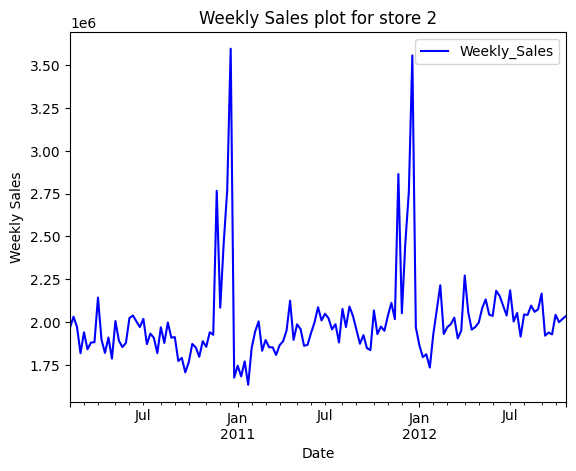

In [6]:
store_13.plot(color='blue')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales plot for store 2')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(store_13['Weekly_Sales'], period=52)
print(decompose.plot())
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller
adfulller_result = adfuller(store_13['Weekly_Sales'])
print('P value for the adfuller test: ', adfulller_result[1])
print(True) if adfulller_result[1]<0.05 else print(False)


In [ ]:
train = store_13.iloc[:115]['Weekly_Sales']
test = store_13.iloc[115:]['Weekly_Sales']


store_13.plot()

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

p = range(0,6)
d = range(0,4)
q = range(0,6)

pdq_combination = list(itertools.product(p,d,q))

error = []
mape = []
r2score = []
order = []

for pdq in pdq_combination:
    model = ARIMA(train, order=pdq)
    model_fit = model.fit()
    preds = model_fit.predict(len(train), len(train)+len(test)-1)
    rmse = np.sqrt(mean_squared_error(test, preds))
    r2 = r2_score(test, preds)
    error_percent = mean_absolute_percentage_error(test, preds)
    
    error.append(rmse)
    r2score.append(r2)
    order.append(pdq)
    mape.append(error_percent)
    
    

error_df = pd.DataFrame({
    'order': order,
    'rmse': error,
    'r2score': r2score,
    'mape': error_percent
})

print(error_df.sort_values(by='mape'))
    
    




In [ ]:
error_df['mape'].min()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(0,0,0), seasonal_order=(1,1,1,52))
model_fit = model.fit()

preds = model_fit.predict(len(train), len(train)+len(test)-1)

In [ ]:
store_13.plot()
preds.plot()

In [ ]:
r2_score(test, preds)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test,
                               preds)

#-------------------------------------------------------------------------------------------------------------
# LSTM MODEL BUILDING
#-------------------------------------------------------------------------------------------------------------

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [30]:
store_34 = df[df['Store'] == 34]['Weekly_Sales']
store_34.head()  

Date
2010-02-05    956228.96
2010-02-12    994610.99
2010-02-19    983963.07
2010-02-26    905756.13
2010-03-05    918295.79
Name: Weekly_Sales, dtype: float64

In [9]:
#train = store_34.iloc[:110][['Weekly_Sales']]
#test = store_34.iloc[110:][['Weekly_Sales']]

scaler = MinMaxScaler(feature_range=(0,1))

#scaler.fit(train)  

df1 = scaler.fit_transform(np.array(store_34).reshape(-1,1))

In [10]:
df1.shape

(143, 1)

In [11]:
training_size = int(len(df1)*0.75)
testing_size = len(df1)-training_size

train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [12]:
training_size, testing_size

(107, 36)

In [13]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
        
    return np.array(dataX),  np.array(dataY)

In [14]:
time_step = 12 
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
y_test.shape, x_test.shape

((23,), (23, 12))

In [16]:
# Reshaping the data to [no.samples, no.columns, no.features]

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [17]:
x_test.shape, y_test.shape

((23, 12, 1), (23,))

In [18]:
## Building the model 

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape = (12,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(1))

#model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\R.Yeshasvin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,810 (120.35 KB)

 Trainable params: 30,810 (120.35 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - loss: 0.0410 - val_loss: 0.0210
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0478 - val_loss: 0.0129
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0215 - val_loss: 0.0061
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0287 - val_loss: 0.0020
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0219 - val_loss: 0.0016
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0267 - val_loss: 0.0027
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0213 - val_loss: 0.0027
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0215 - val_loss: 0.0022
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0302 - val_loss: 0.0018
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0347 - val_loss: 0.0015
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0267 - val_loss: 0.0014
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0226 - val_l

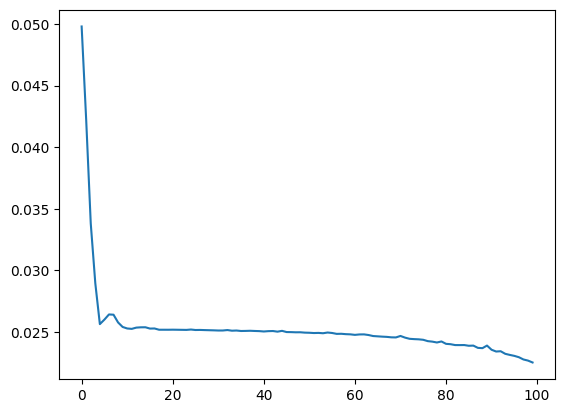

In [21]:
loss = model.history.history['loss']
plt.plot(range(len(loss)), loss)
plt.show()

In [22]:
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [23]:
train_preds = scaler.inverse_transform(train_preds)
test_preds = scaler.inverse_transform( test_preds)

In [ ]:
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))



In [24]:
train_preds.shape

(94, 1)

In [1]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import math

print('RMSE: ', math.sqrt(mean_squared_error(y_train, train_preds)))
print('MAPE: ', mean_absolute_percentage_error(y_train, train_preds))
print('R2 score: ', r2_score(y_train, train_preds))

NameError: name 'y_train' is not defined

In [27]:
y_train = scaler.inverse_transform(y_train.reshape(-1,1))


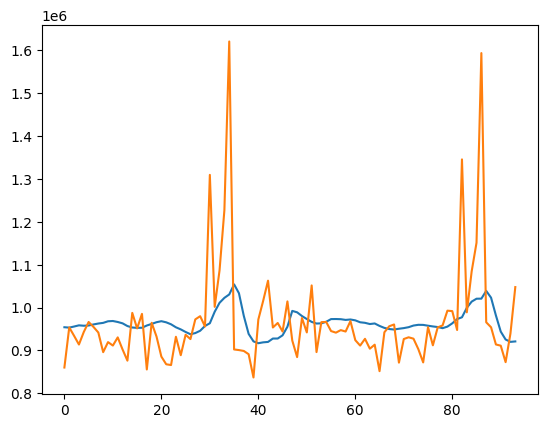

In [28]:
plt.plot(train_preds)
plt.plot(y_train)

In [29]:
y_train.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'